In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from torchvision.models import vgg19, VGG19_Weights


Checking for GPU Availaibility

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
device

device(type='cuda')

In [3]:
content_image_directory = 'content_image.jpg'
style_image_directory = 'style_image.jpg'

Initial DataPreprocessing and basic functions


In [4]:
image_size = 512 if torch.cuda.is_available() else 128
transform = transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.ToTensor()])
def image_loader(image_directory):
  image = Image.open(image_directory)
  image = transform(image).unsqueeze(0)
  return image.to(device, torch.float)

In [5]:
content_img = image_loader(content_image_directory)
style_img = image_loader(style_image_directory)

In [6]:
assert content_img.size() == style_img.size()

In [30]:
reform = transforms.ToPILImage()

def image_unloader(tensor_input,title=None):
  image = tensor_input.cpu().clone()
  image = image.squeeze(0)
  image = reform(image)
  plt.imshow(image)
  plt.title(title)
  plt.show()
  plt.close()



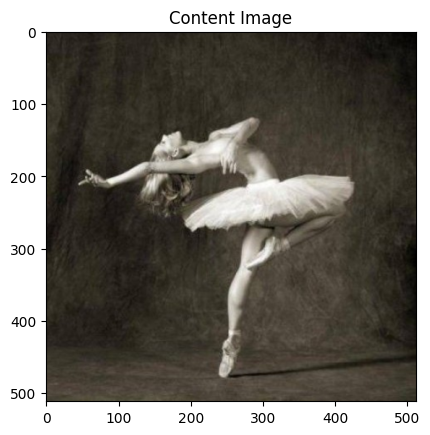

In [31]:
plt.figure()
image_unloader(content_img, title = 'Content Image')


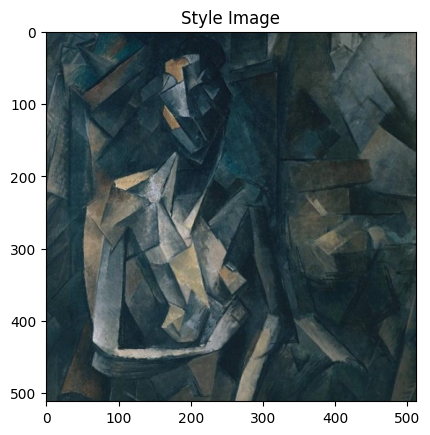

In [9]:
plt.figure()
image_unloader(style_img, title = 'Style Image')

# Loss Functions for Custom Model

In [10]:
class Content_Loss(nn.Module):
  def __init__(self, target):
    super(Content_Loss, self).__init__()
    self.target = target.detach()
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [11]:
def gram_matrix(matrix):
  a,b,c,d = matrix.size()
  features = matrix.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G.div(a*b*c*d)

In [12]:
class Style_Loss(nn.Module):
  def __init__(self, target):
    super(Style_Loss,self).__init__()
    self.target = gram_matrix(target).detach()
  def forward(self, input):
    G_input = gram_matrix(input)
    self.loss = F.mse_loss(G_input, self.target)
    return input


# Pretrained VGG19

In [13]:
vgg = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 104MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [15]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img-self.mean)/self.std


**Content Layers and Style Layers**

In [16]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [17]:
for i in vgg.children():
  print(i)
  break

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Function for getting style and content losses

In [18]:
def style_and_content_losses(pre_model = vgg, normalization_mean=vgg_normalization_mean,
                             normalization_std=vgg_normalization_std,
                                content_layers=content_layers, style_layers=style_layers,
                                content_img=content_img, style_img=style_img):
  normalization = Normalization(vgg_normalization_mean, vgg_normalization_std)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in vgg.children():
    if isinstance(layer, nn.Conv2d):
      i+=1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'ReLU_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'batch_norm_{}'.format(i)
    else:
      raise RuntimeError('Unrecongnized_Layer:{}'.format(layer.__class__.__name__))
    model.add_module(name,layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = Content_Loss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = Style_Loss(target=target_feature)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], Content_Loss) or isinstance(model[i], Style_Loss):
      break

  model = model[:(i+1)]
  return model, style_losses, content_losses

# Input Image same as content Image

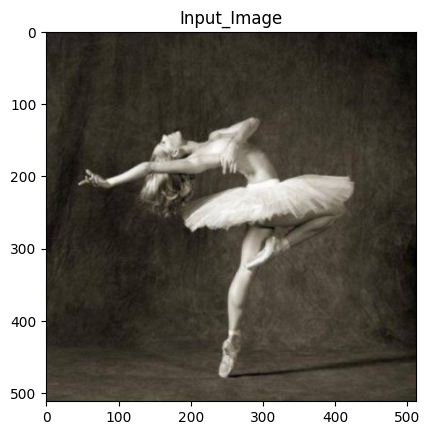

In [19]:
input_img = content_img.clone()
plt.figure()
image_unloader(input_img, title = 'Input_Image')

***Optimizer as suggested by author of reasearch paper***

In [20]:
def get_optimizer(input_img):
  optimizer = torch.optim.LBFGS([input_img])
  return optimizer

In [21]:
# model, style_loss, content_losses = style_and_content_losses(vgg_normalization_mean, vgg_normalization_std,
#                                 content_layers, style_layers,
#                                 content_img, style_img)
# model, style_loss, content_losses

# Final Function for Neural Transfer

In [22]:
def style_transfer(pre_model=vgg, normalization_mean=vgg_normalization_mean,
                   normalization_std=vgg_normalization_std,
                   content_img=content_img, style_img=style_img,
                   input_img = input_img, num_epochs=400,
                   style_weight=1000000, content_weight=1):
  print('Building the style transfer model')
  model, style_losses, content_losses = style_and_content_losses()
  input_img.requires_grad_(True)
  model.eval()
  model.requires_grad_(False)
  optimizer= get_optimizer(input_img)

  print('Optimizing...')
  run = [0]
  while run[0]<=num_epochs:
    def closure():
      with torch.no_grad():
        input_img.clamp_(0,1)
      optimizer.zero_grad()
      model(input_img)
      style_score=0
      content_score = 0
      for s_loss in style_losses:
        style_score += s_loss.loss
      for c_loss in content_losses:
        content_score += c_loss.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}:'.format(run))
        print('Style_loss : {:4f} & Content_loss : {:4f}'.format(
            style_score.item(), content_score.item()
        ))
        print()
      return style_score + content_score
    optimizer.step(closure)

  with torch.no_grad():
        input_img.clamp_(0, 1)

  return input_img



Getting Output

In [23]:
output = style_transfer()

Building the style transfer model


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing...
run [50]:
Style_loss : 4.008237 & Content_loss : 4.146012

run [100]:
Style_loss : 1.135739 & Content_loss : 3.031179

run [150]:
Style_loss : 0.714863 & Content_loss : 2.651623

run [200]:
Style_loss : 0.481216 & Content_loss : 2.490812

run [250]:
Style_loss : 0.349222 & Content_loss : 2.403970

run [300]:
Style_loss : 0.264658 & Content_loss : 2.349341

run [350]:
Style_loss : 0.214068 & Content_loss : 2.314269

run [400]:
Style_loss : 0.184173 & Content_loss : 2.288790



# **The Output**

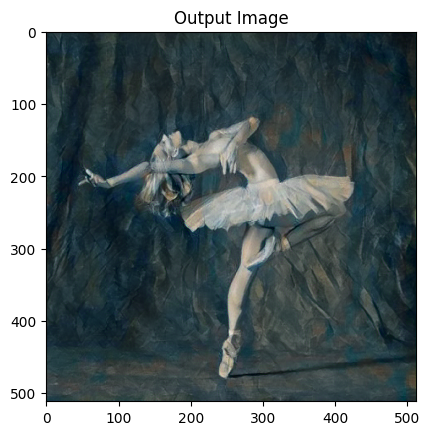

In [24]:
plt.figure()
image_unloader(output, title='Output Image')

plt.ioff()
plt.show()

# ***Initialization with a white noise image***

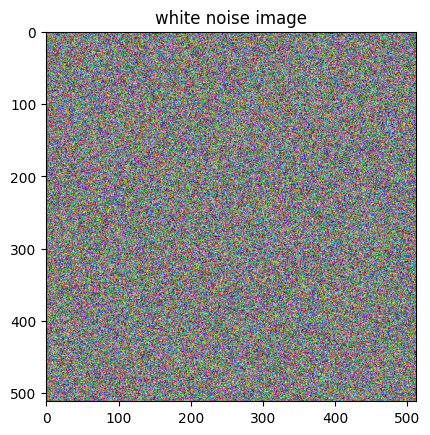

In [32]:
input_img2 = torch.randn(content_img.data.size())
plt.figure()
image_unloader(input_img2, title = 'white noise image')


In [26]:
output2 = style_transfer(input_img=input_img2,num_epochs=700)

Building the style transfer model
Optimizing...
run [50]:
Style_loss : 83.288612 & Content_loss : 11.821552

run [100]:
Style_loss : 23.298397 & Content_loss : 9.524027

run [150]:
Style_loss : 5.048073 & Content_loss : 7.467306

run [200]:
Style_loss : 1.898000 & Content_loss : 5.806565

run [250]:
Style_loss : 1.291034 & Content_loss : 4.793440

run [300]:
Style_loss : 0.958348 & Content_loss : 4.172914

run [350]:
Style_loss : 0.734883 & Content_loss : 3.720185

run [400]:
Style_loss : 0.569834 & Content_loss : 3.423393

run [450]:
Style_loss : 0.448026 & Content_loss : 3.190432

run [500]:
Style_loss : 0.360451 & Content_loss : 3.018604

run [550]:
Style_loss : 0.303826 & Content_loss : 2.879138

run [600]:
Style_loss : 0.262109 & Content_loss : 2.767931

run [650]:
Style_loss : 0.232545 & Content_loss : 2.680881

run [700]:
Style_loss : 0.209969 & Content_loss : 2.609402



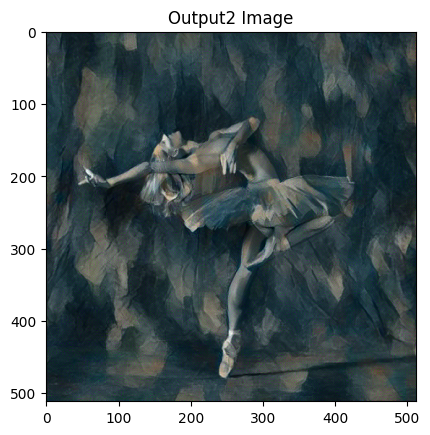

In [33]:
plt.figure()
image_unloader(output2, title='Output2 Image')